In [19]:
import sys
import pandas as pd
import numpy as np

sys.path.append('/home/yuliya/repos/cosybio/FedProt/evaluation_utils/')
from evaluation import evaluation_func as fp_eval

from collections import OrderedDict

In [20]:
color_dict = OrderedDict()

color_dict["Methods"] = OrderedDict({
    "FedProt":"black",
    "Fisher":"#E69F00",
    "Stouffer":"#D44400",
    "REM":"#009E73",
    "RankProd":"#2E5EAA"
})

# Read results

In [21]:
dfs = {}

workdir = "/home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/balanced/results" 
df = fp_eval.read_results(workdir,
                          deqms_name="/central_res.tsv",
                          fedprot_name="/DPE.csv")
dfs["Bacterial dataset"] = df


workdir = "/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/01_smaller_lib_balanced_PG_MajorPG/results" 
df = fp_eval.read_results(workdir,
                          deqms_name="/central_res.tsv",
                          fedprot_name="/DPE.csv")
dfs["Human plasma dataset"] = df

Results loaded from /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/balanced/results with 2232 genes. Adj.p-values were not log-transformed.
Results loaded from /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/01_smaller_lib_balanced_PG_MajorPG/results with 323 genes. Adj.p-values were not log-transformed.


In [22]:
log_dfs = {}
for k in dfs:
    df = dfs[k]
    df = df.replace(0,1e-300)
    df["pv_DEqMS"] = -np.log10(df["pv_DEqMS"])
    for m in ["FedProt", "Fisher","Stouffer","REM","RankProd"]:
        df["pv_"+m] = -np.log10(df["pv_"+m])
    log_dfs[k] = df

# Stats calculation

In [23]:
root_dir = "/home/yuliya/repos/cosybio/FedProt/evaluation/aggregated_eval"

for dataset in dfs:

    pval_basic_stats = fp_eval.calc_stats(
        log_dfs[dataset], 
        lfc_thr=0.58, adj_pval_thr=0.01,
        stats=["MinDiff", "MeanDiff", "MaxDiff", "r", "ρ"],
        methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
        column_name="pv_",
        top_genes=-1
    )
    logfc_basic_stats = fp_eval.calc_stats(
        log_dfs[dataset],
        lfc_thr=0.58, adj_pval_thr=0.01,
        stats=["MinDiff", "MeanDiff", "MaxDiff", "r", "ρ", "NRMSE"],
        methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
        column_name="lfc_",
        top_genes=-1
    )

    pval_basic_stats.to_csv(f'{root_dir}/tables/{dataset}_pval_basic_stats.csv')
    logfc_basic_stats.to_csv(f'{root_dir}/tables/{dataset}_logfc_basic_stats.csv')

    print(f'Dataset: {dataset}')
    print("\tLogFC basic stats:")
    print(logfc_basic_stats)
    print("\tP-value basic stats:")
    print(pval_basic_stats)        

Calculating corrs. Using p-vals - log-transformed.
Correlations computed for all genes from pv_ columns.
RMSE and NRMSE computed for all genes from lfc_ columns.
Correlations computed for all genes from lfc_ columns.
Calculating corrs. Using p-vals - log-transformed.
Correlations computed for all genes from pv_ columns.
RMSE and NRMSE computed for all genes from lfc_ columns.
Correlations computed for all genes from lfc_ columns.


Dataset: Bacterial dataset
	LogFC basic stats:
               MinDiff      MeanDiff       MaxDiff         r         ρ  \
FedProt   0.000000e+00  1.265765e-14  6.039613e-14  1.000000  1.000000   
Fisher    2.182789e-06  2.402043e-03  1.408515e-01  0.999922  0.999866   
Stouffer  2.182789e-06  2.402043e-03  1.408515e-01  0.999922  0.999866   
REM       1.809160e-07  1.430742e-02  2.087504e-01  0.999427  0.998219   
RankProd  2.182789e-06  2.402043e-03  1.408515e-01  0.999922  0.999866   

                 NRMSE  
FedProt   2.028493e-15  
Fisher    1.108840e-03  
Stouffer  1.108840e-03  
REM       2.993511e-03  
RankProd  1.108840e-03  
	P-value basic stats:
           MinDiff      MeanDiff       MaxDiff         r         ρ
FedProt   0.000000  6.721743e-13  4.931167e-12  1.000000  1.000000
Fisher    0.003246  4.821141e+00  3.143238e+01  0.980825  0.956640
Stouffer  0.000202  4.023882e+00  2.717740e+01  0.988544  0.964926
REM       0.000201  1.660669e+01  2.627389e+02  0.766537  0.907563
R

Plotting corrs using p-vals - log-transformed.


Bacterial dataset           Human plasma dataset          
                         r         ρ                    r         ρ
FedProt           1.000000  1.000000             1.000000  1.000000
Fisher            0.980820  0.956391             0.967326  0.912945
Stouffer          0.988540  0.964696             0.965372  0.871612
REM               0.766549  0.907686             0.903433  0.955803
RankProd          0.787204  0.885083             0.729792  0.811142

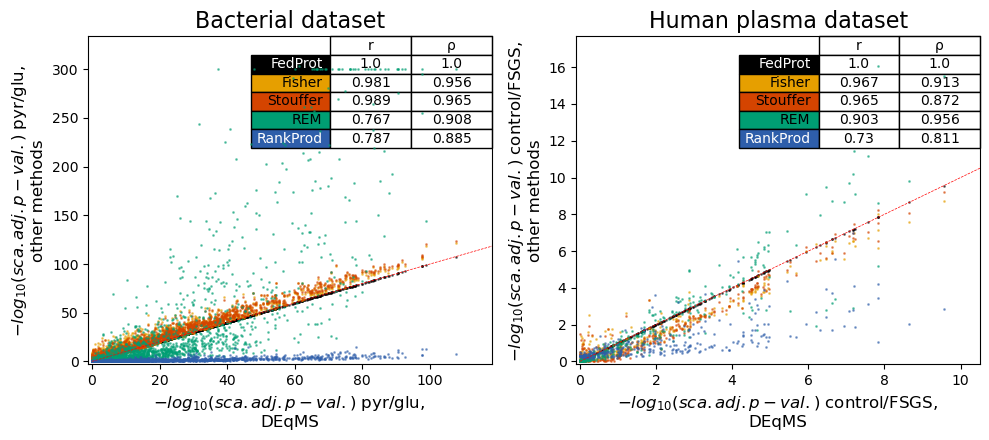

In [24]:
fp_eval.plt_results(
    log_dfs, 
    methods=["FedProt","Fisher","Stouffer","REM","RankProd"],
    color_dict=color_dict,
    what="pv_", 
    text="", dotsize=1,
    datasets=list(log_dfs.keys()),
    add_table=True,
    sharex=False, sharey=False,
    comparsions=["pyr/glu", "control/FSGS"]
)

# plt.savefig("/home/yuliya/repos/cosybio/FedDEqMS/data/04_evaluation/plots/" + "Fig3B_prototype.png", dpi=1200)

Plotting corrs using logFC values.


Bacterial dataset           Human plasma dataset          
                         r         ρ                    r         ρ
FedProt           1.000000  1.000000             1.000000  1.000000
Fisher            0.999922  0.999866             0.999900  0.999841
Stouffer          0.999922  0.999866             0.999900  0.999841
REM               0.999427  0.998218             0.996711  0.995613
RankProd          0.999922  0.999866             0.999900  0.999841

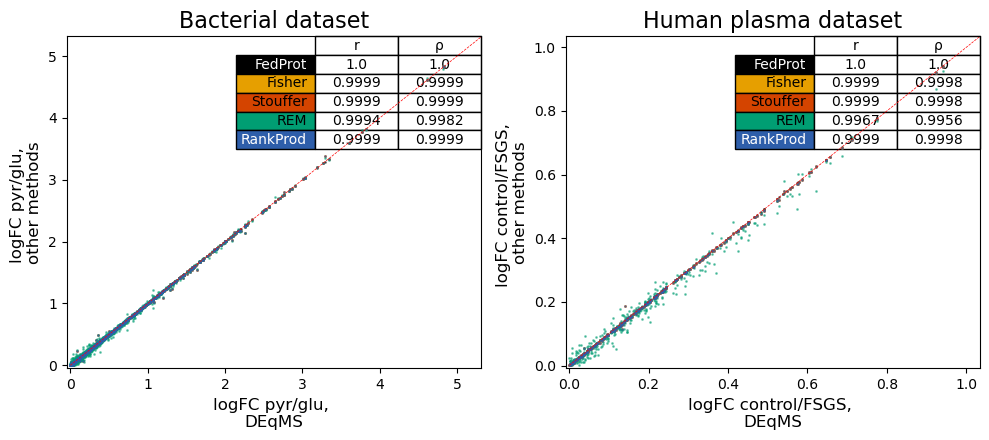

In [25]:
fp_eval.plt_results(
    log_dfs, 
    methods=["FedProt","Fisher","Stouffer","REM","RankProd"],
    color_dict=color_dict,
    what="lfc_", 
    text="", dotsize=1,
    datasets=list(log_dfs.keys()),
    add_table=True,
    sharex=False, sharey=False,
    comparsions=["pyr/glu", "control/FSGS"]
)

# plt.savefig("/home/yuliya/repos/cosybio/FedDEqMS/data/04_evaluation/plots/" + "Fig3B_prototype.png", dpi=1200)

In [27]:
root_dir = "/home/yuliya/repos/cosybio/FedProt/evaluation/aggregated_eval"

fp_fn_b = fp_eval.calc_stats(
    log_dfs["Bacterial dataset"], 
    lfc_thr=0.5, adj_pval_thr=0.05,
    stats=["FP", "FN", "Jaccard"],
    methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
    column_name="pv_",
    top_genes=-1
)

fp_fn_h = fp_eval.calc_stats(
    log_dfs["Human plasma dataset"], 
    lfc_thr=0.25, adj_pval_thr=0.05,
    stats=["FP", "FN", "Jaccard"],
    methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
    column_name="pv_",
    top_genes=-1
)

fp_fn_b.to_csv(f'{root_dir}/tables/Bacterial_FP_FN.csv')
fp_fn_h.to_csv(f'{root_dir}/tables/Human_FP_FN.csv')

print("\tFP/FN bacterial dataset:")
print(fp_fn_b)  
print("\tFP/FN human plasma dataset:")
print(fp_fn_h)

Performance metrics calculated for all genes.
Performance metrics calculated for all genes.


	FP/FN bacterial dataset:
           FP    FN   Jaccard
FedProt   0.0   0.0  1.000000
Fisher    1.0   1.0  0.996627
Stouffer  1.0   1.0  0.996627
REM       6.0  12.0  0.969900
RankProd  0.0  59.0  0.900338
	FP/FN human plasma dataset:
           FP    FN   Jaccard
FedProt   0.0   0.0  1.000000
Fisher    0.0   4.0  0.955056
Stouffer  0.0   8.0  0.910112
REM       4.0   6.0  0.892473
RankProd  2.0  18.0  0.780220


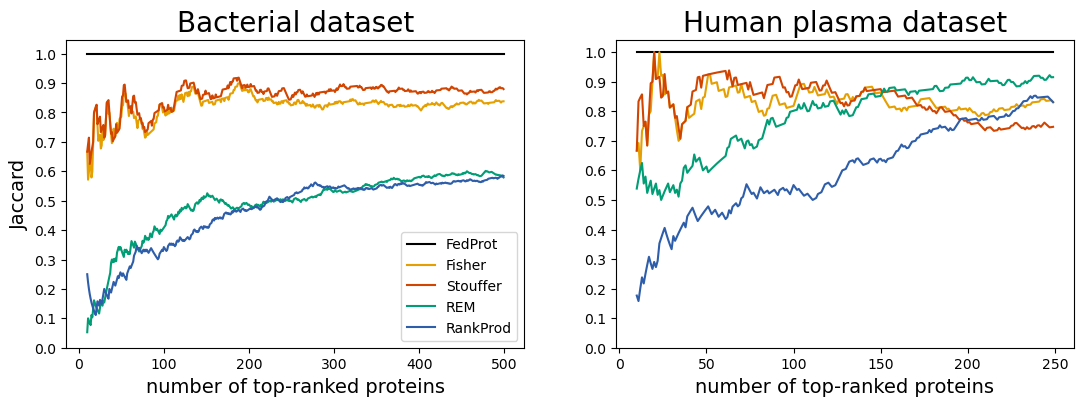

In [16]:
min_n_genes = 10
step = 1

data = fp_eval.plot_stats_for_topN(
    log_dfs,
    datasets = list(log_dfs.keys()),
    methods=["FedProt", "Fisher","Stouffer","REM", "RankProd"],
    metrics=["Jaccard"],
    min_n_genes=min_n_genes,
    max_n_genes=[500, 250],
    step=step,
    color_dict=color_dict,
    sharey=False,
    )